In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [41]:
# import data
df = pd.read_csv("data/train_extended.csv")
data = df.copy()

In [42]:
# make type column one hot encoded
data = pd.get_dummies(data, columns=['Type'], drop_first=True)
data.head()


,id,Product ID,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Temperature_Difference,Speed/Torque_Ratio,Type_L,Type_M
0,0,L50096,300.6,309.6,1596,36.1,140,0,0,0,0,0,0,-9.0,44.210526,1,0
1,1,M20343,302.6,312.1,1759,29.1,200,0,0,0,0,0,0,-9.5,60.446735,0,1
2,2,L49454,299.3,308.5,1805,26.5,25,0,0,0,0,0,0,-9.2,68.113208,1,0
3,3,L53355,301.0,310.9,1524,44.3,197,0,0,0,0,0,0,-9.9,34.401806,1,0
4,4,M24050,298.0,309.0,1641,35.4,34,0,0,0,0,0,0,-11.0,46.355932,0,1


In [43]:
# Get X and y from data
X = data.drop(['Product ID','id','Machine failure','RNF'], axis=1)
y = data['Machine failure']

In [44]:
# Remove [] from column names
X.columns = X.columns.str.replace('[','')
X.columns = X.columns.str.replace(']','')

In [45]:
# Get train and test data
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X,y, random_state=42, train_size=0.85)

In [46]:
# import XGBoost classifier and fit the model
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
final_valid_predictions = []
oof_targets = []
xgb = XGBClassifier(n_estimators=1500,
                    learning_rate=0.05,
                    gamma=0,
                    subsample=0.75,
                    early_stopping_rounds=100,
                    eval_metric='auc',
                    max_depth=10)
xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=100)

evals_result = xgb.evals_result()

y_pred = xgb.predict_proba(X_val)[:, 1]

final_valid_predictions.extend(y_pred)
oof_targets.extend(y_val)

oof_preds = np.array(final_valid_predictions)
oof_targets = np.array(oof_targets)

feature_importance = xgb.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]
features = X.columns

roc_score = roc_auc_score(oof_targets, oof_preds)
print(f"Final ROC AUC score: {roc_score}")


[0]	validation_0-auc:0.93211	validation_1-auc:0.93372
[100]	validation_0-auc:0.98347	validation_1-auc:0.96769
[200]	validation_0-auc:0.99840	validation_1-auc:0.96793
[283]	validation_0-auc:0.99979	validation_1-auc:0.96567
Final ROC AUC score: 0.9684817049881599


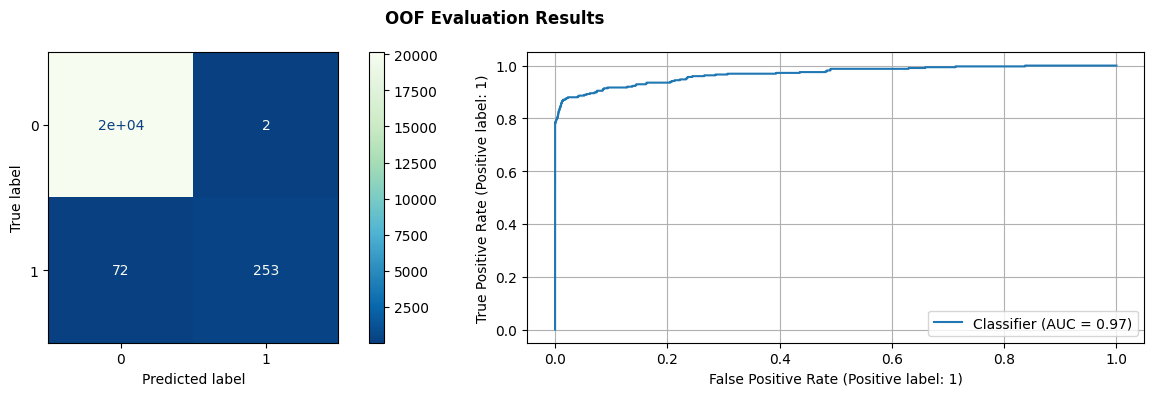

In [47]:
from sklearn.metrics import confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay

def show_confusion_roc(oof, title='Model Evaluation Results'):
    f, ax = plt.subplots(1, 2, figsize=(13.3, 4))
    df = pd.DataFrame(np.stack([oof[0], oof[1]]), index=['preds', 'target']).T
    cm = confusion_matrix(df.target, df.preds.ge(0.5).astype(int))
    cm_display = ConfusionMatrixDisplay(cm).plot(cmap='GnBu_r', ax=ax[0])
    ax[0].grid(False)
    RocCurveDisplay.from_predictions(df.target, df.preds, ax=ax[1])
    plt.suptitle(f'{title}', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.grid()

show_confusion_roc(oof=[oof_preds, oof_targets], title='OOF Evaluation Results')

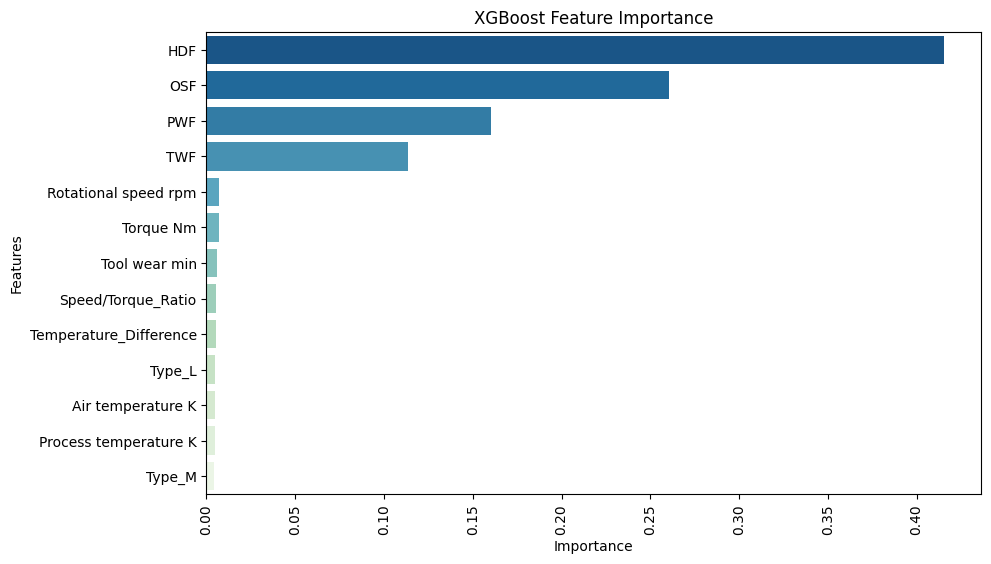

In [48]:
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance[sorted_idx], y=np.array(features)[sorted_idx], palette='GnBu_r')
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance")
plt.xticks(rotation='vertical')
plt.show()

In [10]:
# import test data
test = pd.read_csv("data/test_extended.csv")
test.columns = test.columns.str.replace('[','')
test.columns = test.columns.str.replace(']','')
test = pd.get_dummies(test, columns=['Type'], drop_first=True)
test.drop(['Product ID','id'], axis=1, inplace=True)
test.head()

,Air temperature K,Process temperature K,Rotational speed rpm,Torque Nm,Tool wear min,TWF,HDF,PWF,OSF,RNF,Temperature_Difference,Speed/Torque,Type_L,Type_M
0,302.3,311.5,1499,38.0,60,0,0,0,0,0,-9.2,39.447368,1,0
1,301.7,311.0,1713,28.8,17,0,0,0,0,0,-9.3,59.479167,1,0
2,301.3,310.4,1525,37.7,96,0,0,0,0,0,-9.1,40.450928,1,0
3,300.1,309.6,1479,47.6,5,0,0,0,0,0,-9.5,31.071429,0,1
4,303.4,312.3,1515,41.3,114,0,0,0,0,0,-8.9,36.682809,0,1


In [11]:
submission = pd.read_csv("data/sample_submission.csv")
test_predictions = xgb.predict_proba(test)
predicted_prob = [pred[1] for pred in test_predictions]
predicted_prob[:5]

submission['Machine failure'] = predicted_prob

In [12]:
submission

,id,Machine failure
0,136429,0.001361
1,136430,0.004106
2,136431,0.000586
3,136432,0.001062
4,136433,0.001168
...,...,...
90949,227378,0.001329
90950,227379,0.000767
90951,227380,0.001089
90952,227381,0.000524


In [72]:
submission.to_csv("data/submission.csv", index=False)